# Bangkok :  the district of food
## Introduction
Bangkok is one of the most exciting cities in the world especially if you are a food lover. Bangkok is very famous on food. People always have a hard time when they have to determine what to eat.

In this project, we will provide a dining and restaurant guide for people who plans to travel to Bangkok or even the local people by recommending the top 10 type of restaurant in each district. In addition, this project may useful for a stakeholder who wants to open a restaurant in Bangkok.

## Data Sets and APIs

2. Foursquare API  
This project would use Four-square API as its data gathering source to obtained the venue and restaurant information. Foursquare is a location-based online social network, and Foursquare Places API offers real-time access to its global database for developers to explore the attributes of commercial venues. https://developer.foursquare.com/docs/places-api/


### Bangkok District location data
We will use the table provide in [https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok](https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok) by scraping the website with package Beautiful soup

In [1]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup 

req = requests.get("https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok") 
soup = BeautifulSoup(req.content,'lxml') 
table = soup.find_all('table')[0]  
bkk = pd.read_html(str(table)) 

bkk =pd.DataFrame(bkk[0])
print("We found ",bkk.shape[0]," row and ",bkk.shape[1]," columns of district. The following table show the first 10 rows")
bkk.head(10)

We found  50  row and  8  columns of district. The following table show the first 10 rows


,District(Khet),MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500
5,Bang Khun Thian,21,10150,บางขุนเทียน,165491,2,13.660833,100.435833
6,Bang Na,47,10260,บางนา,95912,2,13.680081,100.591800
7,Bang Phlat,25,10700,บางพลัด,99273,4,13.793889,100.505000
8,Bang Rak,4,10500,บางรัก,45875,5,13.730833,100.524167
9,Bang Sue,29,10800,บางซื่อ,132234,2,13.809722,100.537222


In [2]:
bkk = bkk.drop(['MapNr','Post-code','Thai'],1)
bkk.rename(index=str, columns={"District(Khet)":"District","Popu-lation":"Population","No. ofSubdis-trictsKhwaeng":"num_subdistrict"},inplace=True)

In [3]:
bkk.head()

,District,Population,num_subdistrict,Latitude,Longitude
0,Bang Bon,105161,4,13.659200,100.399100
1,Bang Kapi,148465,2,13.765833,100.647778
2,Bang Khae,191781,4,13.696111,100.409444
3,Bang Khen,189539,2,13.873889,100.596389
4,Bang Kho Laem,94956,3,13.693333,100.502500


In [4]:
bkk.dtypes

District            object
Population           int64
num_subdistrict      int64
Latitude           float64
Longitude          float64
dtype: object

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

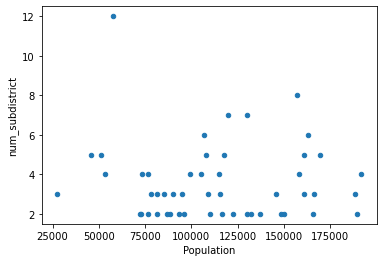

In [6]:
#scatter plot of population and no. of subdistrict
bkk.plot(kind="scatter",y="num_subdistrict",x="Population")
plt.show()

In [7]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# create map of Bangkok using latitude and longitude values 13.736717, 100.523186
# for the purpose of visualize, we manually adjust the center of the map

map_bkk = folium.Map(location=[13.76, 100.6], zoom_start=11)

# add markers to map
for lat, lng, district in zip(bkk['Latitude'], bkk['Longitude'], bkk['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_bkk)  
    
map_bkk

## Foursquare

In [8]:
#Foursquare credential and versions

#Hide credential detail
CLIENT_ID = '0XP33P2YTO5FSJN4F4XUXVIXREEZTAVU1GLDYHV5UXB5NYEA' # your Foursquare ID
CLIENT_SECRET = 'DNBVVHTS1O0QWGURKQH4BCLNLHG02D0DQH0EGM0KS5QC1JLO' # your Foursquare Secret
VERSION = '20210117' # Foursquare API version

In [9]:
#Get the top 100 venues nearby each district within a radius of 2000 meters.
#We use categoryId = 4d4b7105d754a06374d81259 which is food (https://developer.foursquare.com/docs/build-with-foursquare/categories/)
radius = 2000
LIMIT = 100

venues = []

for lat, long, district in zip(bkk['Latitude'], bkk['Longitude'], bkk['District']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06374d81259".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            district, 
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [10]:
# convert the venues list into a DataFrame
venues_df = pd.DataFrame(venues)

# name the column
venues_df.columns = ['District', 'DistrictLatitude', 'DistrictLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(4156, 7)


,District,DistrictLatitude,DistrictLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
1,Bang Bon,13.6592,100.3991,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant
2,Bang Bon,13.6592,100.3991,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.654137,100.405323,Noodle House
3,Bang Bon,13.6592,100.3991,KFC,13.670449,100.405502,Fast Food Restaurant
4,Bang Bon,13.6592,100.3991,Burger King (เบอร์เกอร์คิง),13.670830,100.405089,Fast Food Restaurant


In [11]:
venues_df.groupby(["District"]).count()

,DistrictLatitude,DistrictLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
District,,,,,,
Bang Bon,64,64,64,64,64,64
Bang Kapi,100,100,100,100,100,100
Bang Khae,72,72,72,72,72,72
Bang Khen,67,67,67,67,67,67
Bang Kho Laem,100,100,100,100,100,100
Bang Khun Thian,82,82,82,82,82,82
Bang Na,63,63,63,63,63,63
Bang Phlat,100,100,100,100,100,100
Bang Rak,100,100,100,100,100,100


In [12]:
#Content analysis: how many unique categories can found in the list of venues?
print('There are {} unique categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 86 unique categories.


In [13]:
venue_unique_count = venues_df['VenueCategory'].value_counts().to_frame(name='Count')
venue_unique_count.head(20)

,Count
Noodle House,684
Thai Restaurant,610
Café,316
Asian Restaurant,230
Japanese Restaurant,206
Som Tum Restaurant,176
Chinese Restaurant,165
Restaurant,148
Hotpot Restaurant,135
Fast Food Restaurant,133


## Analyze Neighborhood

In [14]:
# one hot encoding
bkk_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add District column back to dataframe
bkk_onehot['District'] = venues_df['District'] 

# move District column to the first column
fixed_columns = list(bkk_onehot.columns[-1:]) + list(bkk_onehot.columns[:-1])
bkk_onehot = bkk_onehot[fixed_columns]

print(bkk_onehot.shape)
bkk_onehot.head()

(4156, 87)


,District,Afghan Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,...,Takoyaki Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yoshoku Restaurant
0,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Group the rows by Neighborhood, then compute mean occurrence by category
bkk_grouped = bkk_onehot.groupby(["District"]).mean().reset_index()

print(bkk_grouped.shape)
bkk_grouped

(50, 87)


,District,Afghan Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,...,Takoyaki Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yoshoku Restaurant
0,Bang Bon,0.000000,0.000000,0.078125,0.000000,0.000000,0.000000,0.015625,0.000000,0.015625,...,0.00,0.00,0.203125,0.00,0.00,0.000000,0.015625,0.000000,0.000000,0.00
1,Bang Kapi,0.000000,0.000000,0.010000,0.000000,0.040000,0.020000,0.000000,0.000000,0.000000,...,0.00,0.00,0.120000,0.00,0.00,0.000000,0.000000,0.010000,0.010000,0.00
2,Bang Khae,0.000000,0.000000,0.055556,0.000000,0.055556,0.055556,0.000000,0.013889,0.000000,...,0.00,0.00,0.111111,0.00,0.00,0.013889,0.000000,0.000000,0.000000,0.00
3,Bang Khen,0.000000,0.000000,0.089552,0.000000,0.029851,0.014925,0.000000,0.000000,0.000000,...,0.00,0.00,0.119403,0.00,0.00,0.000000,0.000000,0.044776,0.000000,0.00
4,Bang Kho Laem,0.000000,0.000000,0.060000,0.000000,0.040000,0.000000,0.020000,0.020000,0.010000,...,0.00,0.00,0.190000,0.00,0.00,0.000000,0.010000,0.010000,0.000000,0.00
5,Bang Khun Thian,0.000000,0.000000,0.048780,0.000000,0.012195,0.036585,0.000000,0.000000,0.000000,...,0.00,0.00,0.134146,0.00,0.00,0.000000,0.000000,0.036585,0.000000,0.00
6,Bang Na,0.000000,0.000000,0.079365,0.015873,0.000000,0.031746,0.015873,0.000000,0.000000,...,0.00,0.00,0.158730,0.00,0.00,0.000000,0.000000,0.000000,0.015873,0.00
7,Bang Phlat,0.000000,0.000000,0.070000,0.000000,0.030000,0.020000,0.000000,0.000000,0.000000,...,0.00,0.00,0.270000,0.00,0.00,0.000000,0.000000,0.030000,0.000000,0.00
8,Bang Rak,0.000000,0.000000,0.020000,0.000000,0.040000,0.010000,0.010000,0.020000,0.000000,...,0.00,0.00,0.120000,0.00,0.01,0.000000,0.020000,0.000000,0.000000,0.00
9,Bang Sue,0.000000,0.000000,0.020000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.240000,0.00,0.00,0.000000,0.020000,0.000000,0.000000,0.00


# Top 10 venue of each neighborhood

In [16]:
#Now create a dataframe that displays the top 10 venues by PostalCode.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['District']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = bkk_grouped['District']

for ind in np.arange(bkk_grouped.shape[0]):
    row_categories = bkk_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    district_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# district_venues_sorted.sort_values(freqColumns, inplace=True)
print(district_venues_sorted.shape)
district_venues_sorted

(50, 11)


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Thai Restaurant,Noodle House,Asian Restaurant,Café,Japanese Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,Food Truck,Hotpot Restaurant
1,Bang Kapi,Noodle House,Thai Restaurant,Som Tum Restaurant,Fast Food Restaurant,Japanese Restaurant,Steakhouse,BBQ Joint,Hotpot Restaurant,Café,Shabu-Shabu Restaurant
2,Bang Khae,Thai Restaurant,Noodle House,Japanese Restaurant,Fast Food Restaurant,Hotpot Restaurant,Asian Restaurant,Seafood Restaurant,BBQ Joint,Bakery,Steakhouse
3,Bang Khen,Noodle House,Thai Restaurant,Asian Restaurant,Som Tum Restaurant,Steakhouse,Fast Food Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Seafood Restaurant,Restaurant
4,Bang Kho Laem,Thai Restaurant,Noodle House,Chinese Restaurant,Hotpot Restaurant,Asian Restaurant,Restaurant,Seafood Restaurant,BBQ Joint,Japanese Restaurant,Café
5,Bang Khun Thian,Thai Restaurant,Noodle House,Steakhouse,Hotpot Restaurant,Japanese Restaurant,Fast Food Restaurant,Asian Restaurant,Pizza Place,Seafood Restaurant,Vietnamese Restaurant
6,Bang Na,Thai Restaurant,Noodle House,Café,Fast Food Restaurant,Som Tum Restaurant,Asian Restaurant,Restaurant,Bakery,Seafood Restaurant,Food Truck
7,Bang Phlat,Thai Restaurant,Noodle House,Café,Asian Restaurant,Fast Food Restaurant,Som Tum Restaurant,Restaurant,BBQ Joint,Vietnamese Restaurant,Japanese Restaurant
8,Bang Rak,Noodle House,Thai Restaurant,Café,Seafood Restaurant,Chinese Restaurant,Japanese Restaurant,French Restaurant,Restaurant,BBQ Joint,Ramen Restaurant
9,Bang Sue,Thai Restaurant,Noodle House,Som Tum Restaurant,Fast Food Restaurant,Café,BBQ Joint,Hotpot Restaurant,Steakhouse,Seafood Restaurant,Vegetarian / Vegan Restaurant


## Clustering using K-Means clustering

In [17]:
#import k-means
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

bkk_grouped_clustering = bkk_grouped.drop(["District"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bkk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 0, 0, 3, 0, 2, 4, 2, 1])

In [18]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
bkk_merged = bkk.copy()

# add clustering labels
bkk_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bkk_merged = bkk_merged.join(district_venues_sorted.set_index("District"), on="District")

print(bkk_merged.shape)
bkk_merged.head()

(50, 16)


,District,Population,num_subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,105161,4,13.659200,100.399100,2,Thai Restaurant,Noodle House,Asian Restaurant,Café,Japanese Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,Food Truck,Hotpot Restaurant
1,Bang Kapi,148465,2,13.765833,100.647778,0,Noodle House,Thai Restaurant,Som Tum Restaurant,Fast Food Restaurant,Japanese Restaurant,Steakhouse,BBQ Joint,Hotpot Restaurant,Café,Shabu-Shabu Restaurant
2,Bang Khae,191781,4,13.696111,100.409444,0,Thai Restaurant,Noodle House,Japanese Restaurant,Fast Food Restaurant,Hotpot Restaurant,Asian Restaurant,Seafood Restaurant,BBQ Joint,Bakery,Steakhouse
3,Bang Khen,189539,2,13.873889,100.596389,0,Noodle House,Thai Restaurant,Asian Restaurant,Som Tum Restaurant,Steakhouse,Fast Food Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Seafood Restaurant,Restaurant
4,Bang Kho Laem,94956,3,13.693333,100.502500,3,Thai Restaurant,Noodle House,Chinese Restaurant,Hotpot Restaurant,Asian Restaurant,Restaurant,Seafood Restaurant,BBQ Joint,Japanese Restaurant,Café


In [19]:
#Elbow criterion method
# Import key libraries
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

In [20]:
# create map
map_clusters = folium.Map(location=[13.76, 100.6], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, district, cluster in zip(bkk_merged['Latitude'], bkk_merged['Longitude'], bkk_merged['District'], bkk_merged['Cluster Labels']):
    label = folium.Popup('{} : Cluster {}'.format(district, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [21]:
bkk_merged[bkk_merged['Cluster Labels']==0].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bang Kapi,0,Noodle House,Thai Restaurant,Som Tum Restaurant,Fast Food Restaurant,Japanese Restaurant,Steakhouse,BBQ Joint,Hotpot Restaurant,Café,Shabu-Shabu Restaurant
2,Bang Khae,0,Thai Restaurant,Noodle House,Japanese Restaurant,Fast Food Restaurant,Hotpot Restaurant,Asian Restaurant,Seafood Restaurant,BBQ Joint,Bakery,Steakhouse
3,Bang Khen,0,Noodle House,Thai Restaurant,Asian Restaurant,Som Tum Restaurant,Steakhouse,Fast Food Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Seafood Restaurant,Restaurant
5,Bang Khun Thian,0,Thai Restaurant,Noodle House,Steakhouse,Hotpot Restaurant,Japanese Restaurant,Fast Food Restaurant,Asian Restaurant,Pizza Place,Seafood Restaurant,Vietnamese Restaurant
13,Chatuchak,0,Thai Restaurant,Noodle House,Café,Fast Food Restaurant,Som Tum Restaurant,Japanese Restaurant,Hotpot Restaurant,Chinese Restaurant,BBQ Joint,Bakery
15,Din Daeng,0,Japanese Restaurant,Thai Restaurant,Som Tum Restaurant,Steakhouse,Noodle House,Sushi Restaurant,Restaurant,Bakery,Seafood Restaurant,Café
18,Huai Khwang,0,Noodle House,Thai Restaurant,Som Tum Restaurant,Asian Restaurant,Café,Japanese Restaurant,Hotpot Restaurant,Seafood Restaurant,Korean Restaurant,BBQ Joint
19,Khan Na Yao,0,Thai Restaurant,Japanese Restaurant,Noodle House,BBQ Joint,Som Tum Restaurant,Asian Restaurant,Café,Bakery,Steakhouse,Ramen Restaurant
22,Khlong Toei,0,Café,Japanese Restaurant,Thai Restaurant,Noodle House,Ramen Restaurant,Italian Restaurant,Bakery,Hotpot Restaurant,Som Tum Restaurant,BBQ Joint
30,Phasi Charoen,0,Thai Restaurant,Noodle House,BBQ Joint,Fast Food Restaurant,Som Tum Restaurant,Steakhouse,Asian Restaurant,Hotpot Restaurant,Café,Japanese Restaurant


In [22]:
bkk_merged[bkk_merged['Cluster Labels']==1].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Bang Sue,1,Thai Restaurant,Noodle House,Som Tum Restaurant,Fast Food Restaurant,Café,BBQ Joint,Hotpot Restaurant,Steakhouse,Seafood Restaurant,Vegetarian / Vegan Restaurant
17,Dusit,1,Noodle House,Thai Restaurant,Café,Asian Restaurant,Som Tum Restaurant,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Food Court,Hotpot Restaurant
33,Phra Nakhon,1,Noodle House,Thai Restaurant,Café,Asian Restaurant,Bakery,Chinese Restaurant,Vegetarian / Vegan Restaurant,Hotpot Restaurant,Dim Sum Restaurant,Italian Restaurant
38,Sai Mai,1,Noodle House,Thai Restaurant,Restaurant,Asian Restaurant,Vietnamese Restaurant,Seafood Restaurant,Food Truck,Café,Steakhouse,Pizza Place
43,Taling Chan,1,Noodle House,Café,Thai Restaurant,Som Tum Restaurant,Japanese Restaurant,Asian Restaurant,Restaurant,Seafood Restaurant,Steakhouse,Diner
44,Thawi Watthana,1,Noodle House,Thai Restaurant,Café,Asian Restaurant,Chinese Restaurant,Restaurant,Bakery,Breakfast Spot,Steakhouse,Soup Place


In [23]:
bkk_merged[bkk_merged['Cluster Labels']==2].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,2,Thai Restaurant,Noodle House,Asian Restaurant,Café,Japanese Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,Food Truck,Hotpot Restaurant
6,Bang Na,2,Thai Restaurant,Noodle House,Café,Fast Food Restaurant,Som Tum Restaurant,Asian Restaurant,Restaurant,Bakery,Seafood Restaurant,Food Truck
8,Bang Rak,2,Noodle House,Thai Restaurant,Café,Seafood Restaurant,Chinese Restaurant,Japanese Restaurant,French Restaurant,Restaurant,BBQ Joint,Ramen Restaurant
12,Bueng Kum,2,Noodle House,Thai Restaurant,Café,Japanese Restaurant,Bakery,Restaurant,Fast Food Restaurant,Hotpot Restaurant,Chinese Restaurant,Asian Restaurant
16,Don Mueang,2,Noodle House,Thai Restaurant,Fast Food Restaurant,Café,Japanese Restaurant,Snack Place,Bakery,Pizza Place,Asian Restaurant,Restaurant
20,Khlong Sam Wa,2,Noodle House,Thai Restaurant,Restaurant,Café,Chinese Restaurant,Diner,Buffet,Asian Restaurant,Japanese Restaurant,French Restaurant
23,Lak Si,2,Thai Restaurant,Noodle House,Restaurant,Café,Food Court,Som Tum Restaurant,Japanese Restaurant,Chinese Restaurant,Fast Food Restaurant,Bakery
28,Nong Khaem,2,Noodle House,Thai Restaurant,Hotpot Restaurant,Steakhouse,Restaurant,Fast Food Restaurant,Café,Sushi Restaurant,Ramen Restaurant,Chinese Restaurant
31,Phaya Thai,2,Thai Restaurant,Noodle House,Som Tum Restaurant,Japanese Restaurant,Café,Restaurant,Sushi Restaurant,Food Court,Bakery,Steakhouse
40,Saphan Sung,2,Thai Restaurant,Noodle House,Japanese Restaurant,Asian Restaurant,Café,Fast Food Restaurant,Restaurant,Bakery,Food Truck,Chinese Restaurant


In [24]:
bkk_merged[bkk_merged['Cluster Labels']==3].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bang Kho Laem,3,Thai Restaurant,Noodle House,Chinese Restaurant,Hotpot Restaurant,Asian Restaurant,Restaurant,Seafood Restaurant,BBQ Joint,Japanese Restaurant,Café
10,Bangkok Noi,3,Noodle House,Thai Restaurant,Som Tum Restaurant,Café,Japanese Restaurant,Steakhouse,Seafood Restaurant,Asian Restaurant,BBQ Joint,Diner
11,Bangkok Yai,3,Noodle House,Thai Restaurant,Asian Restaurant,Steakhouse,Chinese Restaurant,Japanese Restaurant,Café,Seafood Restaurant,Fast Food Restaurant,BBQ Joint
21,Khlong San,3,Noodle House,Chinese Restaurant,Thai Restaurant,Seafood Restaurant,Café,Asian Restaurant,Restaurant,Hotpot Restaurant,Japanese Restaurant,Indian Restaurant
25,Lat Phrao,3,Noodle House,Thai Restaurant,Chinese Restaurant,Café,Japanese Restaurant,Restaurant,Steakhouse,Sushi Restaurant,Hotpot Restaurant,BBQ Joint
29,Pathum Wan,3,Noodle House,Asian Restaurant,Café,Thai Restaurant,Korean Restaurant,Chinese Restaurant,BBQ Joint,Bakery,Seafood Restaurant,Restaurant
34,Pom Prap Sattru Phai,3,Noodle House,Asian Restaurant,Café,Thai Restaurant,Chinese Restaurant,Bakery,Seafood Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Som Tum Restaurant
36,Rat Burana,3,Thai Restaurant,Noodle House,Chinese Restaurant,Asian Restaurant,Hotpot Restaurant,Restaurant,Japanese Restaurant,BBQ Joint,Seafood Restaurant,Som Tum Restaurant
39,Samphanthawong,3,Noodle House,Chinese Restaurant,Café,Thai Restaurant,Seafood Restaurant,Asian Restaurant,Restaurant,Breakfast Spot,Italian Restaurant,French Restaurant
41,Sathon,3,Noodle House,Thai Restaurant,Asian Restaurant,Café,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Som Tum Restaurant,BBQ Joint,Bakery


In [25]:
bkk_merged[bkk_merged['Cluster Labels']==4].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bang Phlat,4,Thai Restaurant,Noodle House,Café,Asian Restaurant,Fast Food Restaurant,Som Tum Restaurant,Restaurant,BBQ Joint,Vietnamese Restaurant,Japanese Restaurant
14,Chom Thong,4,Thai Restaurant,Hotpot Restaurant,Noodle House,BBQ Joint,Food Truck,Asian Restaurant,Shabu-Shabu Restaurant,Restaurant,Som Tum Restaurant,Steakhouse
24,Lat Krabang,4,Thai Restaurant,Noodle House,Som Tum Restaurant,Café,Steakhouse,Hotpot Restaurant,Japanese Restaurant,Asian Restaurant,BBQ Joint,Seafood Restaurant
26,Min Buri,4,Thai Restaurant,Restaurant,Asian Restaurant,Diner,Café,Noodle House,Italian Restaurant,Halal Restaurant,Fried Chicken Joint,Fast Food Restaurant
27,Nong Chok,4,Thai Restaurant,Noodle House,Café,Asian Restaurant,Halal Restaurant,BBQ Joint,Snack Place,Restaurant,Steakhouse,Food Truck
49,Yan Nawa,4,Thai Restaurant,Café,Noodle House,Steakhouse,Seafood Restaurant,Japanese Restaurant,Som Tum Restaurant,Bakery,Asian Restaurant,Restaurant


## Ranking Venues in every cluster

In [26]:
# Now I create separate dataframes for each cluster
cluster_0=bkk_merged[bkk_merged['Cluster Labels']==0].drop(['Population','num_subdistrict','Latitude','Longitude'],1)
cluster_1=bkk_merged[bkk_merged['Cluster Labels']==1].drop(['Population','num_subdistrict','Latitude','Longitude'],1)
cluster_2=bkk_merged[bkk_merged['Cluster Labels']==2].drop(['Population','num_subdistrict','Latitude','Longitude'],1)
cluster_3=bkk_merged[bkk_merged['Cluster Labels']==3].drop(['Population','num_subdistrict','Latitude','Longitude'],1)
cluster_4=bkk_merged[bkk_merged['Cluster Labels']==4].drop(['Population','num_subdistrict','Latitude','Longitude'],1)
#cluster_5=london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
#cluster_6=london_merged.loc[london_merged['Cluster Labels'] == 6, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
#cluster_7=london_merged.loc[london_merged['Cluster Labels'] == 7, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

# and then separate dataframe where the points will be allocated
cluster_0_rank=pd.DataFrame(columns=['Venues','Points'])
cluster_1_rank=pd.DataFrame(columns=['Venues','Points'])
cluster_2_rank=pd.DataFrame(columns=['Venues','Points'])
cluster_3_rank=pd.DataFrame(columns=['Venues','Points'])
cluster_4_rank=pd.DataFrame(columns=['Venues','Points'])

The following function will rank venues using scores from 10 to 1 points

In [32]:
score={2:10, 3:9, 4:8, 5:7, 6:6, 7:5, 8:4, 9:3, 10:2, 11:1}

def make_score(cluster_, cluster_rank):
    for r in range(0,len(cluster_)):
        for c in range(2,11):

            if cluster_.iloc[r,c] in list(cluster_rank['Venues']):
                cluster_rank.iloc[cluster_rank[cluster_rank['Venues']==cluster_.iloc[r,c]].index.item(),1]+=score.get(c)
            elif cluster_.iloc[r,c] not in list(cluster_rank['Venues']):
                cluster_rank.loc[len(cluster_rank)]=[cluster_.iloc[r,c],0]
                cluster_rank.iloc[cluster_rank[cluster_rank['Venues']==cluster_.iloc[r,c]].index.item(),1]+=score.get(c)
            else:
                print(f'Error on ({r},{c})')
                
    cluster_rank.columns=['Venues','Cluster '+ str(int(cluster_.iloc[0,1]))]           
    cluster_rank.sort_values(['Cluster '+ str(int(cluster_.iloc[0,1]))], ascending=False,inplace=True)
    cluster_rank.set_index(['Venues'], inplace=True)

clusters=[cluster_0,cluster_1,cluster_2,cluster_3,cluster_4]
clusters_rank=[cluster_0_rank,cluster_1_rank,cluster_2_rank,cluster_3_rank,cluster_4_rank]

In [33]:
for i in range(0,len(clusters)):
    make_score(clusters[i], clusters_rank[i])

## Results and Discussion
### Plotting Trending venues in every neighourhood

In [34]:
cluster_0_rank.head()

,Cluster 0
Venues,
Thai Restaurant,328
Noodle House,327
Japanese Restaurant,236
Som Tum Restaurant,199
Café,169


array([<AxesSubplot:title={'center':'Cluster 4'}>], dtype=object)

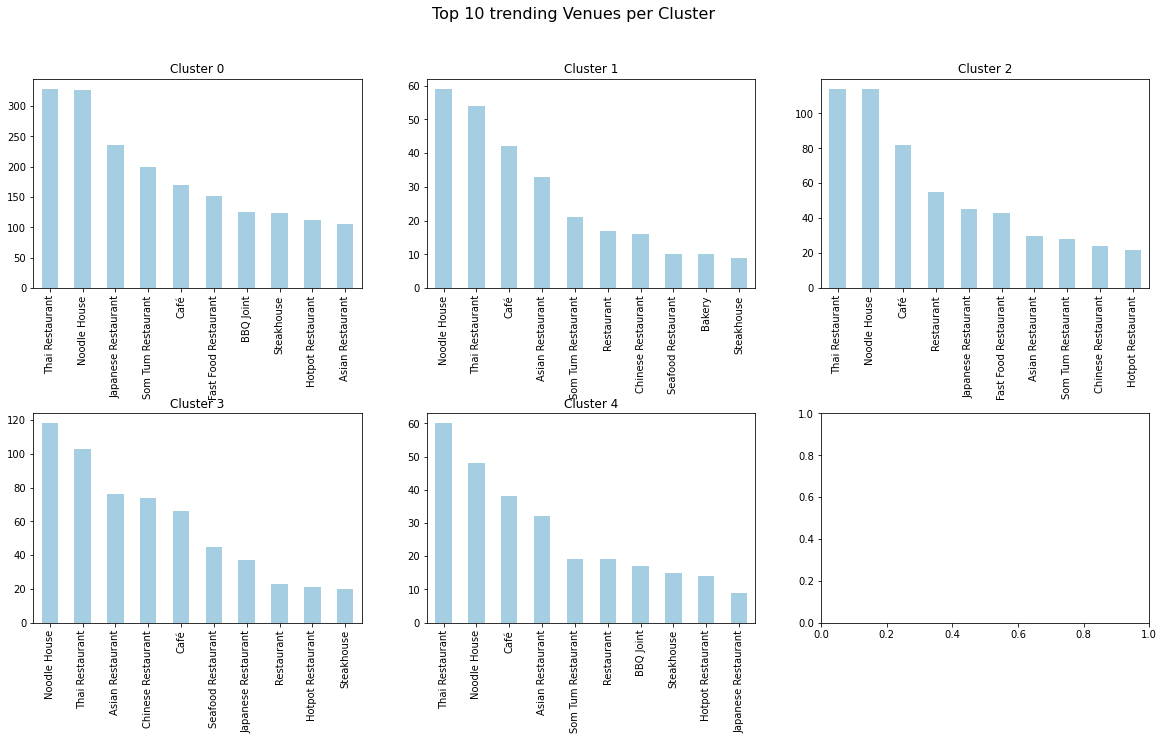

In [42]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
fig.suptitle('Top 10 trending Venues per Cluster', fontsize=16)
plt.subplots_adjust(hspace=0.6)

cluster_0_rank.head(10).plot.bar(ax=axes[0,0],figsize=(6,6),subplots=True, legend=False, colormap='Paired', xlabel='')
cluster_1_rank.head(10).plot.bar(ax=axes[0,1],figsize=(6,6),subplots=True, legend=False, colormap='Paired', xlabel='')
cluster_2_rank.head(10).plot.bar(ax=axes[0,2],figsize=(6,6),subplots=True, legend=False, colormap='Paired', xlabel='')
cluster_3_rank.head(10).plot.bar(ax=axes[1,0],figsize=(6,6),subplots=True, legend=False, colormap='Paired', xlabel='')
cluster_4_rank.head(10).plot.bar(ax=axes[1,1],figsize=(6,6),subplots=True, legend=False, colormap='Paired', xlabel='')

In [41]:
cluster_0_rank

,Cluster 0
Venues,
Thai Restaurant,328
Noodle House,327
Japanese Restaurant,236
Som Tum Restaurant,199
Café,169
Fast Food Restaurant,152
BBQ Joint,125
Steakhouse,123
Hotpot Restaurant,112


Elbow https://nbviewer.jupyter.org/github/OLGit2020/IBM-Data-Science-Capstone-Project-2021/blob/main/COURSERA%20IBM%20DATA%20SCIENCE%20PROJECT.Notebook.2021.01.ipynb

First clustering of the neighborhoods with the k-means algorithm according to the percentage of vegetarian / vegan restaurants
As an unsupervised learning, the k-means algorithm is used for clustering. I will use it to segment the neighborhoods of my dataframe into several groups, called “clusters”, in function of the competition variable. Indeed, the neighborhoods will be grouped in function of their similarities, in terms of percentage of vegetarian and vegan restaurants.

First of all, I need to determine the best number of clusters with the “Elbow method”. With this method, I determine a range of potential values for “k”: between 2 and 10. For each of this value, I compute the total within-cluster sum of squared distances. Then, I plot it as a curve on a graph in function of the number of clusters. As a result, I can determine the best “k” value where the curve represents an elbow.

In [ ]:
num_top_venues = 5

for hood in Toronto_grouped['Borough']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')